In [6]:
# Code for a 3-layer neural network, and code for learning the MNIST dataset
# This version creates additional training examples by rotating each original by +/- 10 degrees

In [12]:
# numpy provides arrays and useful functions for working with them
import numpy
# scipy.special for the sigmoid function expit()
import scipy.special
# scipy.ndimage for rotating image arrays
import scipy.ndimage
import matplotlib.pyplot as plt

In [2]:
# neural network class definition
class neuralNetwork:
    
    
    # initialise the neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # set number of nodes in each input, hidden, output layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        # link weight matrices, wih and who
        # weights inside the arrays are w_i_j, where link is from node i to node j in the next layer
        # w11 w21
        # w12 w22 etc 
        self.wih = numpy.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))

        # learning rate
        self.lr = learningrate
        
        # activation function is the sigmoid function
        self.activation_function = lambda x: scipy.special.expit(x)
        self.inverse_activation_function = lambda x: scipy.special.logit(x) 
        # "logit()" is an inversed function of "expit()"
        
        pass

    
    # train the neural network
    def train(self, inputs_list, targets_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        # output layer error is the (target - actual)
        output_errors = targets - final_outputs
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden_errors = numpy.dot(self.who.T, output_errors)
        
        # update the weights for the links between the hidden and output layers
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))
        
        # update the weights for the links between the input and hidden layers
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))
        
        pass

    
    # query the neural network
    def query(self, inputs_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs
    
    # From label (output's array represent a number) --> output picture of this label (as input in normal way)
    def backquery(self, targets_list): 
        # transpose the targets list to a vertical array
        final_outputs = numpy.array(targets_list, ndmin=2).T
        
        # calculate the signal into the final output layer
        final_inputs = self.inverse_activation_function(final_outputs)

        # calculate the signal out of the hidden layer
        hidden_outputs = numpy.dot(self.who.T, final_inputs)
        # scale them back to 0.01 to .99
        hidden_outputs -= numpy.min(hidden_outputs)
        hidden_outputs /= numpy.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        
        # calculate the signal into the hidden layer
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        
        # calculate the signal out of the input layer
        inputs = numpy.dot(self.wih.T, hidden_inputs)
        # scale them back to 0.01 to .99
        inputs -= numpy.min(inputs)
        inputs /= numpy.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs

In [3]:
# number of input, hidden and output nodes
input_nodes = 784
hidden_nodes = 200
output_nodes = 10

# learning rate
learning_rate = 0.01

# create instance of neural network
nn_model = neuralNetwork(input_nodes,hidden_nodes,output_nodes, learning_rate)

In [4]:
# load the mnist training data CSV file into a list
training_data_file = open("data/mnist_train.csv", 'r')
training_data_list = training_data_file.readlines()[1:]
training_data_file.close()

In [5]:
# train the neural network

# epochs is the number of times the training data set is used for training
epochs = 5

for e in range(epochs):
    # go through all records in the training data set
    for record in training_data_list:
        # split the record by the ',' commas
        all_values = record.split(',')
        # scale and shift the inputs
        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        # create the target output values (all 0.01, except the desired label which is 0.99)
        targets = numpy.zeros(output_nodes) + 0.01
        # all_values[0] is the target label for this record
        targets[int(all_values[0])] = 0.99
        nn_model.train(inputs, targets)
        
        ## create rotated variations
        # rotated anticlockwise by x degrees
        inputs_plusx_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28,28), 10, cval=0.01, order=1, reshape=False)
        nn_model.train(inputs_plusx_img.reshape(784), targets)
        # rotated clockwise by x degrees
        inputs_minusx_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28,28), -10, cval=0.01, order=1, reshape=False)
        nn_model.train(inputs_minusx_img.reshape(784), targets)
        
        # "reshape=False": prevent library from being overly helpful and squishing the image
        # so that it all fits after the rotation 
        # "cval" value to fill in empty array elements after rotating
        
        pass
    pass

- **Rotations**: A technique which rotates the image to x degree for improving the result of "Performance"
<br>
- **"ndimage.interpolation.rotate()"** create an array by a given angle, which is exactly what we need for this technique

In [8]:
# load the mnist test data CSV file into a list
test_data_file = open("data/mnist_test.csv", 'r')
test_data_list = test_data_file.readlines()[1:]
test_data_file.close()

In [9]:
# test the neural network

# scorecard for how well the network performs, initially empty
scorecard = []

# go through all the records in the test data set
for record in test_data_list:
    # split the record by the ',' commas
    all_values = record.split(',')
    # correct answer is first value
    correct_label = int(all_values[0])
    # scale and shift the inputs
    inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    # query the network
    outputs = nn_model.query(inputs)
    # the index of the highest value corresponds to the label
    label = numpy.argmax(outputs)
    # append correct or incorrect to list
    if (label == correct_label):
        # network's answer matches correct answer, add 1 to scorecard
        scorecard.append(1)
    else:
        # network's answer doesn't match correct answer, add 0 to scorecard
        scorecard.append(0)
        pass
    
    pass

In [10]:
# calculate the performance score, the fraction of correct answers
scorecard_array = numpy.asarray(scorecard)
performance = scorecard_array.sum() / scorecard_array.size
print (f"performance = {performance*100}%")

performance = 97.04%


### Some techniques for improving the result's quality & understand more model

- **Rotations**: A technique which rotates the image to x degree for improving the result of "Performance"
<br>
- **"ndimage.interpolation.rotate()"** create an array by a given angle, which is exactly what we need for this technique

- **"backquery()"**: using target's array (10's units array) as input --> Output an 28\*28 picture's array
<br>
- Sigmoid: y = f(x) --> Transform to activation function used in "backquery()" x=g(y) (Call "logit function") (by using some algebra, y = f(x) -> x = g(y))

Generate 28\*28 picture of  **label 0** with neural network model backward

[0.99 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


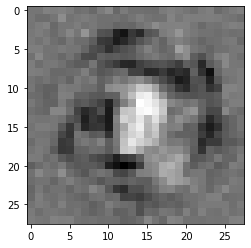

In [13]:
# label to test
label = 0
# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
# all_values[0] is the target label for this record
targets[label] = 0.99
print(targets)

# get image data
image_data = nn_model.backquery(targets)

# plot image data
plt.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')

Generate 28\*28 picture of **label 3** with neural network model backward

[0.01 0.01 0.01 0.99 0.01 0.01 0.01 0.01 0.01 0.01]


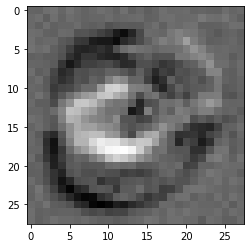

In [17]:
# label to test
label = 3
# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
# all_values[0] is the target label for this record
targets[label] = 0.99
print(targets)

# get image data
image_data = nn_model.backquery(targets)

# plot image data
plt.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')

Generate 28\*28 picture of **label 7** with neural network model backward

[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.99 0.01 0.01]


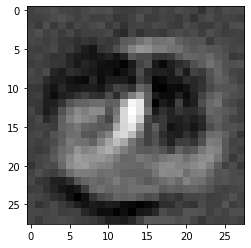

In [19]:
# label to test
label = 7
# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
# all_values[0] is the target label for this record
targets[label] = 0.99
print(targets)

# get image data
image_data = nn_model.backquery(targets)

# plot image data
plt.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')

Generate 28\*28 picture of **label 5** with neural network model backward

[0.01 0.01 0.01 0.01 0.01 0.99 0.01 0.01 0.01 0.01]


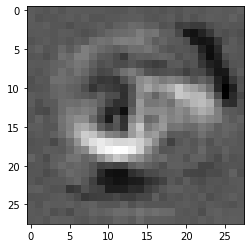

In [20]:
# label to test
label = 5
# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
# all_values[0] is the target label for this record
targets[label] = 0.99
print(targets)

# get image data
image_data = nn_model.backquery(targets)

# plot image data
plt.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')